**策略基本逻辑：**
- 计算历史波动率过去若干天的标准差，得到历史波动率的上下限，即历史波动率+-N倍的标准差
- 计算历史波动率过去若干天的滑动平均值
- 当隐含波动率大于历史波动率的上限并且隐含波动率大于历史波动率的滑动平均值，则卖出跨式组合
- 当隐含波动率小于历史波动率的下限并且隐含波动率小于历史波动率的滑动平均值，则买入跨式组合
- 当隐含波动率落入历史波动率的合理波动范围时平仓

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import math
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
%matplotlib inline

In [36]:
etf_close = pd.read_excel("50ETF.xlsx", "close")
etf_ivx = pd.read_excel("50ETF.xlsx", "iv")
etf_hv = pd.read_excel("50ETF.xlsx", "hv30")
lastdate = pd.read_excel("50ETF.xlsx", "ETF_option_lasttradingdate")
etf_option_name = pd.read_excel("50ETF.xlsx", "at_money_name")

In [37]:
etf_close = pd.DataFrame(etf_close)
etf_close

,date,510050C1503M02200,510050C1503M02250,510050C1503M02300,510050C1503M02350,510050C1503M02400,510050C1503M02450,510050C1503M02500,510050C1503M02550,510050C1503M02600,...,510050P2006M02900,510050P2006M02950,510050P2006M03000,510050P2006M03100,510050P2006M03200,510050P2006M03300,510050P2006M03400,510050P2006M03500,(空白),总计
0,2015-02-09,0.1826,0.1460,0.1225,0.0942,0.0735,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0445
1,2015-02-10,0.2072,0.1659,0.1367,0.1055,0.0855,0.0622,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0485
2,2015-02-11,0.2107,0.1702,0.1363,0.1050,0.0780,0.0591,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2361
3,2015-02-12,0.2109,0.1690,0.1323,0.1009,0.0736,0.0536,0.0373,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.1442
4,2015-02-13,0.2090,0.1677,0.1281,0.0925,0.0659,0.0429,0.0294,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.3338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0630,0.0801,0.1019,0.1539,0.2198,0.2956,0.3793,NaN,NaN,23.9887
1190,2019-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0566,0.0730,0.0934,0.1438,0.2057,0.2790,0.3606,NaN,NaN,19.8598
1191,2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0557,0.0721,0.0916,0.1408,0.2030,0.2769,0.3596,NaN,NaN,20.0853
1192,2019-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0497,0.0646,0.0832,0.1277,0.1844,0.2538,0.3270,NaN,NaN,20.9987


In [39]:
# 填补缺失值：取每列的均值进行填补空值
etf_close.fillna(etf_close.mean())

,date,510050C1503M02200,510050C1503M02250,510050C1503M02300,510050C1503M02350,510050C1503M02400,510050C1503M02450,510050C1503M02500,510050C1503M02550,510050C1503M02600,...,510050P2006M02900,510050P2006M02950,510050P2006M03000,510050P2006M03100,510050P2006M03200,510050P2006M03300,510050P2006M03400,510050P2006M03500,(空白),总计
0,2015-02-09,0.182600,0.146000,0.122500,0.094200,0.0735,0.073293,0.050332,0.0335,0.035129,...,0.074061,0.094078,0.117335,0.173312,0.241147,0.312945,0.394038,0.46029,NaN,7.0445
1,2015-02-10,0.207200,0.165900,0.136700,0.105500,0.0855,0.062200,0.050332,0.0335,0.035129,...,0.074061,0.094078,0.117335,0.173312,0.241147,0.312945,0.394038,0.46029,NaN,8.0485
2,2015-02-11,0.210700,0.170200,0.136300,0.105000,0.0780,0.059100,0.050332,0.0335,0.035129,...,0.074061,0.094078,0.117335,0.173312,0.241147,0.312945,0.394038,0.46029,NaN,7.2361
3,2015-02-12,0.210900,0.169000,0.132300,0.100900,0.0736,0.053600,0.037300,0.0335,0.035129,...,0.074061,0.094078,0.117335,0.173312,0.241147,0.312945,0.394038,0.46029,NaN,8.1442
4,2015-02-13,0.209000,0.167700,0.128100,0.092500,0.0659,0.042900,0.029400,0.0335,0.035129,...,0.074061,0.094078,0.117335,0.173312,0.241147,0.312945,0.394038,0.46029,NaN,7.3338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,2019-12-25,0.260839,0.214664,0.173839,0.134136,0.1013,0.073293,0.050332,0.0335,0.035129,...,0.063000,0.080100,0.101900,0.153900,0.219800,0.295600,0.379300,0.46029,NaN,23.9887
1190,2019-12-26,0.260839,0.214664,0.173839,0.134136,0.1013,0.073293,0.050332,0.0335,0.035129,...,0.056600,0.073000,0.093400,0.143800,0.205700,0.279000,0.360600,0.46029,NaN,19.8598
1191,2019-12-27,0.260839,0.214664,0.173839,0.134136,0.1013,0.073293,0.050332,0.0335,0.035129,...,0.055700,0.072100,0.091600,0.140800,0.203000,0.276900,0.359600,0.46029,NaN,20.0853
1192,2019-12-30,0.260839,0.214664,0.173839,0.134136,0.1013,0.073293,0.050332,0.0335,0.035129,...,0.049700,0.064600,0.083200,0.127700,0.184400,0.253800,0.327000,0.46029,NaN,20.9987


In [41]:
fee = 5.0    #手续费
slippage = 5.0    #滑点（与交易量有关）
capital = 1000000.0
size = 50    #根据资金情况，可以做50个跨式期权策略，50手看涨+50手看跌
option_value = 0    #初始值
remain_money = capital    #盈亏情况， remain_money = capital + capital_change + option_value
total_money = [remain_money]
trade_option = pd.DataFrame()

### 回测参数设置
open_b = 1.5    #开仓进场条件，历史波动率 +- 1.5倍的标准差
close_b = 0.0001    #平仓条件，历史波动率 + 0.0001倍的标准差，


def add_open(num, call_name, put_name):
    # 正在开仓中的合约
    global trade_option        # global为函数外的变量赋值，是全局的，不是局部的
    if trade_option.empty:
        t = pd.Series([call_name, put_name, num], index=["call","put"])
        trade_option = trade_option.append(t, ignore_index=True)
    else:
        if call_name not in trade_option["call"].values:
            t = pd.Series([call_name,put_name,num], index=["call"])
            trade_option = trade_option.append(t, ignore_index=True)
    return trade_option

In [46]:
## 记录交易日期，交易内容，交易仓位
d = []
trade_content = []
trade_position = []    #资金状态。买期权，卖期权，平买，平卖


def straddle(date, position, call_name, put_name):  # 资金处理
    global size,trade_option
    call_close = etf_close[etf_close.date==date][call_name].values[0]
    put_close = etf_close[etf_close.date==date][put_name].values[0]
    
    if position=="buy":  # 买跨式期权
        num = size
        add_open(num, call_name, put_name)
        d.append(date)
        trade_position.append("buy")
        trade_content.append('buy: ' + str(call_name) + 'and buy' + str(put_name)) 
        print(str(date) + 'buy: ' + str(call_name) + 'and buy' + str(put_name)) 
        money_change = -10000.0*size*call_close - 10000.0*size*put_close
    elif position == "sell":  # 卖跨式期权
        num = size
        add_open(num, call_name, put_name)
        d.append(date)
        trade_position.append("sell")
        trade_content.append('sell: ' + str(call_name) + ' and sell' + str(put_name)) 
        print(str(date) + 'buy: ' + str(call_name) + 'and sell' + str(put_name)) 
        money_change = 10000.0*size*call_close - 10000.0*size*put_close
    elif position == "close_buy":  # 对冲多头--卖出期权
        trade_option = trade_option[trade_option['call'] != call_name]
        d.append(date)
        trade_position.append("close buy")
        trade_content.append('close buy: ' + str(call_name) + 'and close buy' + str(put_name)) 
        print(str(date) + 'close buy: ' + str(call_name) + 'and close buy' + str(put_name)) 
        money_change = 10000.0*size*call_close - 10000.0*size*put_close
    elif position == "close_sell":  # 冲销空头--买入期权
        trade_option = trade_option[trade_option['call'] != call_name]
        d.append(date)
        trade_position.append("close sell")
        trade_content.append('close sell: ' + str(call_name) + 'and close sell' + str(put_name)) 
        print(str(date) + 'close sell: ' + str(call_name) + 'and close sell' + str(put_name)) 
        money_change = -10000.0*size*call_close - 10000.0*size*put_close
        
    return money_change - 2*size*fee -2*size*slippage/2.0

In [54]:
## 构造长（20日） 短（5日）均线
#短均线
ma5 = [0,0,0,0,0]
a =0
for i in np.arange(5,905,1):
    ma5.append((etf_hv.hv[i-1] + etf_hv.hv[i-2] + etf_hv.hv[i-3] + etf_hv.hv[i-4] + etf_hv.hv[i-5])/5) 
    
#长均线
ma20 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
b = 0
for i in np.arange(20,905,1):
    for j in np.arange(1,21):
        b += etf_hv.hv[i-j]
    ma20.append(b/20)
    b = 0
    
# plot ma5 and ma20
#plt.title('Moving Average Lines')
#plt.plot(etf_hv.date, ma5, linestyle='-.', color='black', label='MA5')
#plt.plot(etf_hv.date, ma20, color='red', label='MA20')
#plt.legend()
#plt.xlabel('Date')
#plt.ylabel('Average hv')
#plt.savefig("MAL.png")
#plt.show()

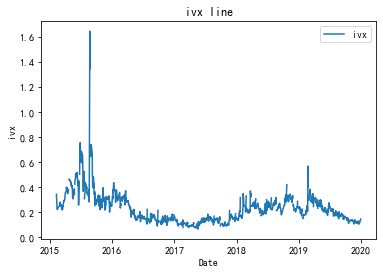

In [57]:
# 计算ivx
# 构造ivx曲线
ivx1 = []
# 计算ivx的函数
def cal_ivx(date):
    call_name = etf_option_name[etf_option_name.date==date]['call'].values[0]  
    put_name = etf_option_name[etf_option_name.date==date]['put'].values[0]  
    call_ivx = etf_ivx[etf_ivx.date==date][call_name].values[0]
    put_ivx = etf_ivx[etf_ivx.date==date][put_name].values[0]
    return ((call_ivx + put_ivx) / 2)

### 画出平值期权附近期权的隐含波动率
for date in etf_option_name.date.values:
    ivx1.append(cal_ivx(date))
    
#plot ivx
plt.title('ivx line')
plt.plot(etf_option_name.date, ivx1, label='ivx')
plt.legend()
plt.xlabel('Date')
plt.ylabel('ivx')
plt.savefig("ivx.png")
plt.show()

In [79]:
# 连接成DataFrame
c = {"number":range(905), "date":etf_hv.date, "ma5":ma5, "ma20":ma20} 
etf_hv1 = pd.DataFrame.from_dict(c, orient='index')


########
## 计算hv的标准差（时段为20天）
#hv30plus = etf_hv['hv'].values.tolist()
#hv30_std = [(np.array(hv30plus)[i:i+20]).std() for i in range(len(hv30plus))] 
#hv30_std = etf_hv['hv_std']


## 开仓平仓交易
def handle_ivx(date):
    global remain_money
    hv = etf_hv[etf_hv.date==date]['hv'].values[0]
    hvstd = etf_hv[etf_hv.date==date]['hv_std'].values[0]
    call_name = etf_option_name[etf_option_name.date==date]['call'].values[0]
    put_name = etf_option_name[etf_option_name.date==date]['put'].values[0]
    call_ivx = etf_ivx[etf_ivx.date==date][call_name].values[0]
    put_ivx = etf_ivx[etf_ivx.date==date][put_name].values[0]
    ivx = (call_ivx + put_ivx)/2
    option_value = 0
    number = int(etf_hv1[etf_hv1.date==date].number)
    
    ## 开仓
    if trade_option.empty:
        if ivx > hv + open_b * hvstd and (ivx > etf_hv1.ma20[number]):
            call_close = etf_close[etf_close.date==date][call_name].values[0]
            put_close = etf_close[etf_close.date==date][put_name].values[0]
            position = 'sell'
            change = straddle(date, position, call_name, put_name)
            option_value = option_value - 10000.0 * size * call_close - 10000.0 * size * put_close
        elif ivx < hv - open_b * hvstd and (ivx < etf_hv1.ma20[number]):
            call_close = etf_close[etf_close.date==date][call_name].values[0]
            put_close = etf_close[etf_close.date==date][put_name].values[0]
            position = 'buy'
            change = straddle(date, position, call_name, put_name)
            option_value = option_value + 10000.0 * size * call_close + 10000.0 * size * put_close  
        else:
            chnage = 0
    else:
        
    ## 平仓    
        for call_name in trade_option['call']:
            num = trade_option[trade_opttion['call']==call_name]["size"].values.tolist()[0]
            put_name = trade_option[trade_option['call']==call_name]["put"].values.tolist()[0]
            
            if (hv-close_b*hvstd < ivx < hv+close_b*hvstd or expire(call_name, date)=="T") and num > 0:
                position = 'close buy'
                change = straddle(date, position, call_name, put_name)
            elif (hv < ivx < etf_hv1.ma20[number] or expire(call_name, date)=="T") and num < 0:
                position = 'close sell'
                change = straddle(date, position, call_name, put_name)
            else:
                call_close = etf_close[etf_close.date==date][call_name].vvalues[0]
                put_close = etf_close[etf_close.date==date][put_name].values[0]
                option_value = option_value + 10000.0 * num *call_close + 10000.0 * num * put_close
                change = 0
                
    remain_money += change
    total_money.append(remain_money + option_value)

In [ ]:
# 判断看涨期权是否到期的函数
def expire(call_name, date):
    if date in lastdate.lasttradingdate.values and (call_name in lastdate[lastdate.lasttradingdate==date]['symbol']): 
        expireTF = "T"
    else:
        expireTF = "F"
    return expireTF


########
day=[]
for date in etf_option_name.date.values:
    handle_ivx(date)
    date = pd.to_datetime(str(date)).strftime('%Y-%m-%d')  
    date = datetime.strptime(date, '%Y-%m-%d')
    day.append(date)

In [ ]:
DAY_MAX = len(total_money)

def cal_performance():
    ## Annualized return, Sharp ratio, Maximal drawdown, Sortino ratio
    rtn = total_money[-1] / capital - 1

    annual_rtn = np.power(rtn + 1, 252.0 / DAY_MAX) - 1  # 复利计算
    annual_rtn = rtn*252 / DAY_MAX  # 单利计算
    print(total_money)
    #annual_lst = [(total_money[k + 1] - total_money[k]) / total_money] 
    annual_vol = np.array(total_money).std() * np.sqrt(252.0)    #标准差
    
    rf = 0.04
    
    #semi_down_list = list(filter(lambda x: True if x < rf/252 else False, annual_lst))
    # semi_down_list = [annual_lst[k] < rf/252 for k in range(trade_period - 1)]
    #semi_down_vol = np.array(semi_down_list).std() * np.sqrt(252)
    sharp_ratio = (annual_rtn -rf) / annual_vol
    #sortino_ratio = (annual_rtn -rf) / semi_down_vol
    
    max_drawdown_ratio = 0
    for e, i in enumerate(total_money):
        for f, j in enumerate(total_money):
            if f > e and float(j -i) / i < max_drawdown_ratio:
                max_drawdown_ratio = float(j - i) / i
    return annual_rtn, max_drawdown_ratio, annual_vol, sharp_ratio

backtest_return = total_money[-1] / capital -1
annualized, max_drawdown, rtn_vol, sharp = cal_performance()


### 回测绩效与绘图
print('Return: %.2f%%' % (backtest_return * 100.0))
print('Annualized Return: %.2f%%' % (annualized * 100.0))
print('Maximal Drawdown: %.2f%%' % (max_drawdown * 100.0))
print('Annualized Vol: %.2f%%' % (100.0 * rtn_vol))
print('Sharp Ratio: %.4f' % sharp)
#print('Sortino Ratio: %.4f' % sortino)



# sns.set_style('white')
plt.figure(figsize=(8,5))
plt.plot(day, total_money[1:])
plt.xlabel('Date')
plt.ylabel('Money')
plt.title('Money Curve')
plt.grid(True)
plt.savefig("result.png")
plt.show()